In [156]:
import numpy as np
import pandas as pd
import os
from functions.poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.optimize import curve_fit
from itertools import starmap

from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [157]:
pd.options.mode.chained_assignment = None  # default='warn'

# Prepare data

## colors

In [158]:
colors = pd.read_csv('dane_pdf/woj_col.csv', index_col=0)
colors

,wojewodztwo,color
0,ŚLĄSKIE,black
1,OPOLSKIE,slategray
2,WIELKOPOLSKIE,darkred
3,ZACHODNIOPOMORSKIE,deeppink
4,ŚWIĘTOKRZYSKIE,darkorange
5,KUJAWSKO-POMORSKIE,bisque
6,PODLASKIE,gold
7,DOLNOŚLĄSKIE,olive
8,PODKARPACKIE,green
9,MAŁOPOLSKIE,lime


## Percent voting people

In [159]:
voter_w = pd.read_csv('dane_years/voters/percent_voters.csv',header=None)

## Poll data

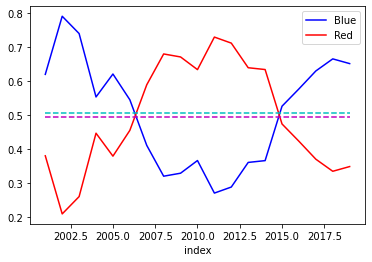

In [160]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/no_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Voting data

In [161]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [162]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [163]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [164]:
vote_list[0] = vote_list[0].set_index('województwo')

## Neighbours

In [165]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Stat data

In [166]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [167]:
stat_list_org = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files]

In [168]:
for s in stat_list_org:
    s['wyksztalcenie_wyzsze'] = s['wyksztalcenie_wyzsze'].fillna(0)

In [170]:
stat_list_org[0].isna().sum(0)

emeryci_i_rencisci                   0
bezrobocie_zarejsestrowane           0
bezrobocie_zarejsestrowane_gminy    16
malzenstwa_zawarte                   0
ludnosc_na_1km2                     16
dochody_gminy                        0
dochody_na_mieszkanca               16
wyksztalcenie_wyzsze                 0
wyksztalcenie_gim_pod_nizsze         0
wyksztalcenie_srednie                0
rozwody_powiat                       0
udzial_wiek_przedprodukcyjny        16
udzial_wiek_produkcyjny             16
udzial_wiek_poprodukcyjny           16
praca_najemna                        0
praca_wlasny_rachunek                0
socjal_500plus                      16
socjal                               0
dochody_brutto_na_mieszkanca         0
PKB_na_1_mieszkanca                  0
przestepstwa_ogolem                 16
dtype: int64

In [171]:
stat_list_org[0].columns[stat_list_org[0].isna().sum(0) > 0]

Index(['bezrobocie_zarejsestrowane_gminy', 'ludnosc_na_1km2',
       'dochody_na_mieszkanca', 'udzial_wiek_przedprodukcyjny',
       'udzial_wiek_produkcyjny', 'udzial_wiek_poprodukcyjny',
       'socjal_500plus', 'przestepstwa_ogolem'],
      dtype='object')

In [172]:
data = [['mazowieckie',35558], 
['wielkopolskie',29826], 
['lubelskie',25122], 
['warmińsko-mazurskie',24173], 
['zachodniopomorskie',22892], 
['podlaskie',20187], 
['dolnośląskie',19947], 
['pomorskie',18310], 
['łódzkie',18219], 
['kujawsko-pomorskie',17972], 
['podkarpackie',17846], 
['małopolskie',15183], 
['lubuskie',13988], 
['śląskie',12333], 
['świętokrzyskie',11711], 
['opolskie',9412]]

woj_pow = pd.DataFrame(data, columns=['jednostka','powierzchnnia_km2'])

In [173]:
woj_pow['jednostka'] = woj_pow['jednostka'] .str.upper() 

In [174]:
for s in range(len(stat_list_org)):
    stat_list_org[s] = pd.merge(stat_list_org[s], woj_pow, left_index=True, right_on='jednostka')
    stat_list_org[s] = stat_list_org[s].set_index('jednostka')

## Use 2 approaches to estimate date from years without elections

In [175]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0].iloc[:,:-1]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0].iloc[:,:-1]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
    
    par_in_reg_list.append(party_in_region(df_vote.iloc[:,:-1], pool[1]))
    reg_in_par_list.append(region_in_party(df_vote.iloc[:,:-1], pool[1]))

In [176]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]
    reg_in_par_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]

In [177]:
pool_d = par_in_reg_list if (False) else reg_in_par_list 

In [178]:
pool_d_plot = []
voter_percent = voter_w.iloc[:,1].values
for p in pool_d:
    pool_d_plot.append(np.average(np.average(p['Blue'].values,weights = voter_percent)))

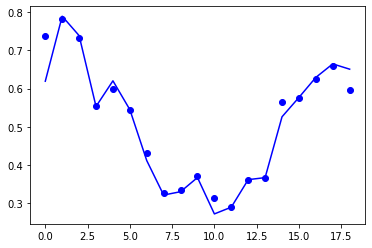

In [179]:
plt.plot(pool_d_plot,'bo')
plt.plot(pool_data_middle['Blue'].values ,'b-')
plt.show()

## Approximating ludnosc_na_1km2

In [180]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)

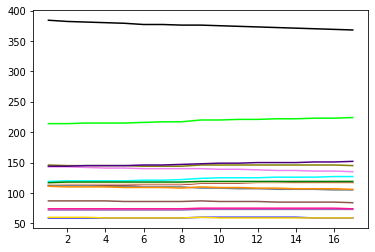

In [181]:
data_reshaped = pool_stat_df_org['ludnosc_na_1km2'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/ludnosc_na_1km2_all.pdf',  bbox_inches='tight')

In [182]:
def lq_lin(x, a, b):
    return x*a + b 

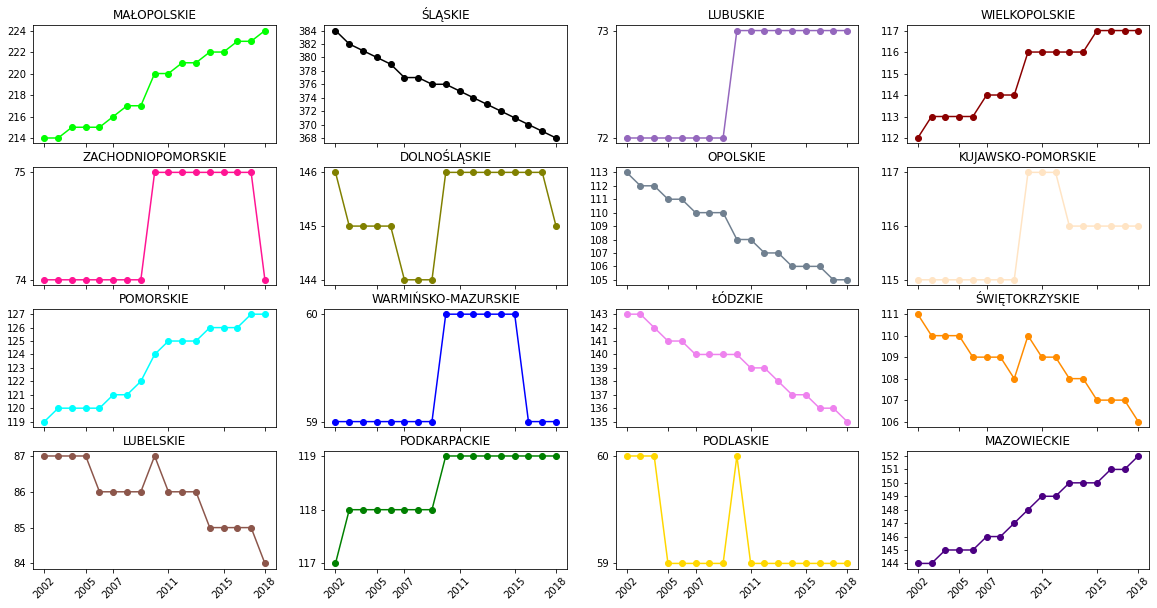

In [183]:
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

x = np.arange(17)

fig = plt.figure(1, figsize=(20,10))
 
for w in range(data_reshaped.shape[1]):
    (a,b), pcov = curve_fit(lq_lin, x, data_reshaped[1:,w], p0=[1,1])
    xmodel = np.arange(18)
    ymodel = lq_lin(xmodel, a, b)
    
    ax1 = fig.add_subplot(4,4,w+1)
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[1:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    #ax1.plot(xmodel,ymodel, "r--", label="Model")
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
        #plt.xticks([str(i) for i in range(2002,2018)], rotation=45)
    #ax.set_xticklabels(xlabels, rotation=40, ha=ha[n])
    #stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.savefig('dane_pdf/dane_stat/ludnosc_na_1km2.pdf',  bbox_inches='tight')

Setup value as last year

In [184]:
for w in range(data_reshaped.shape[1]):
    stat_list_org[0]['ludnosc_na_1km2'][w] = data_reshaped[1,w]

## Creating new stat data

In [185]:
stat_list_org[1].columns[stat_list_org[1].max(0) > 100]

Index(['emeryci_i_rencisci', 'bezrobocie_zarejsestrowane',
       'malzenstwa_zawarte', 'ludnosc_na_1km2', 'dochody_gminy',
       'dochody_na_mieszkanca', 'rozwody_powiat', 'praca_najemna', 'socjal',
       'dochody_brutto_na_mieszkanca', 'PKB_na_1_mieszkanca',
       'przestepstwa_ogolem', 'powierzchnnia_km2'],
      dtype='object')

In [186]:
for s in stat_list_org:
    s['ludnosc'] = s['ludnosc_na_1km2']*s['powierzchnnia_km2']
    s['emeryci_i_rencisci_ludnosc'] = s['emeryci_i_rencisci']/s['ludnosc']
    s['bezrobocie_zarejsestrowane_ludnosc'] = s['bezrobocie_zarejsestrowane']/s['ludnosc']
    s['malzenstwa_zawarte_ludnosc'] = s['malzenstwa_zawarte']/s['ludnosc']
    s['dochody_gminy_ludnosc'] = s['dochody_gminy']/s['ludnosc']
    s['rozwody_powiat_ludnosc'] = s['rozwody_powiat']/s['ludnosc']
    s['przestepstwa_ludnosc'] = s['przestepstwa_ogolem']/s['ludnosc']
    s['rozwody_malzenstwa'] = s['rozwody_powiat']/s['malzenstwa_zawarte']

### Correlation
Corr between real data before scaling and outpots for each party based on rescaled output with poll and real data

In [187]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)

pool_stat_df_org['random'] = np.random.randn(pool_stat_df_org.shape[0])

cols = pool_stat_df_org.columns.tolist()
cols = cols[:-3] + ['random'] + cols[-3:-1]

pool_stat_df_org = pool_stat_df_org[cols]

In [188]:
rand_corr = []
for i in range(1000):
    pool_stat_df_org['random'] = np.random.randn(pool_stat_df_org.shape[0])
    rd_corr = pool_stat_df_org.corr().iloc[-1:,-3].values[0]
    rand_corr.append(np.abs(rd_corr))

0.08316816283490698
0.082


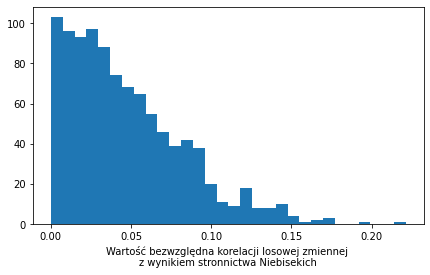

In [189]:
#plt.axhline(np.mean(rand_corr)+np.std(rand_corr))
print(np.mean(rand_corr)+np.std(rand_corr))
#sn.displot(rand_corr,bins=20)
plt.figure(figsize=(7,4))
plt.hist(rand_corr,bins=30)
print((np.array(rand_corr)>0.1).sum()/1000)
#plt.ylabel('Liczba wystapień wartości w dnaym przedziale')
plt.xlabel(f'Wartość bezwzględna korelacji losowej zmiennej \nz wynikiem stronnictwa Niebisekich')
plt.savefig('dane_pdf/dane_stat/random_vvariable_hist.pdf',  bbox_inches='tight')

### Compare Old and New variables

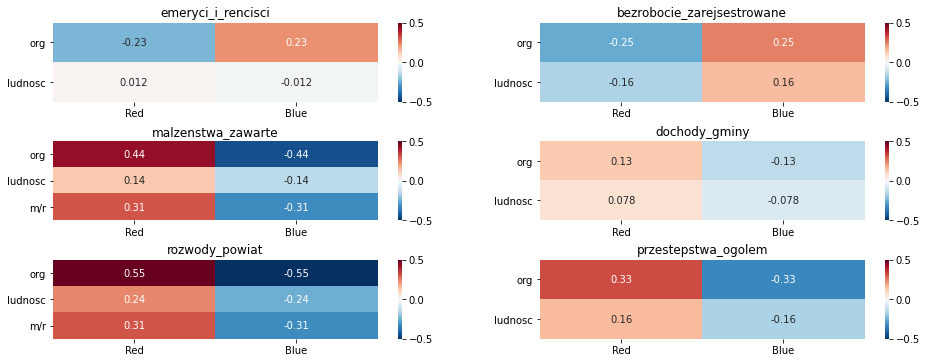

In [190]:
fig = plt.figure(1, figsize=(16,8)) 
plt.subplots_adjust(hspace=0.5)
for w, c in enumerate([
    'emeryci_i_rencisci',
    'bezrobocie_zarejsestrowane',
    'malzenstwa_zawarte',
    'dochody_gminy',
    'rozwody_powiat',
    'przestepstwa_ogolem']):
    #fig, ax = plt.subplots(figsize=(5,2))
    ax = fig.add_subplot(4,2,w+1)
    ax.set_title(c)
    if(c in ['malzenstwa_zawarte', 'rozwody_powiat']):
        tmp = pool_stat_df_org.corr().loc[[c+'_ludnosc',c,'rozwody_malzenstwa'],['Red','Blue']].copy()
        tmp.index = ['org','ludnosc','m/r']
        g = sn.heatmap(tmp,annot=True, cmap='RdBu_r', ax=ax, vmin=-1/2, vmax=1/2)
    elif c == 'przestepstwa_ogolem':
        tmp = pool_stat_df_org.corr().loc[['przestepstwa_ludnosc',c],['Red','Blue']].copy()
        tmp.index = ['org','ludnosc']
        g = sn.heatmap(tmp,annot=True, cmap='RdBu_r', ax=ax, vmin=-1/2, vmax=1/2)
    else:
        tmp = pool_stat_df_org.corr().loc[[c+'_ludnosc',c],['Red','Blue']].copy()
        tmp.index = ['org','ludnosc']
        g = sn.heatmap(tmp,annot=True, cmap='RdBu_r', ax=ax, vmin=-1/2, vmax=1/2)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)

plt.savefig('dane_pdf/dane_stat/corrs_new_old.pdf',  bbox_inches='tight')

In [191]:
(pool_stat_df_org
                       .corr()
                       .iloc[-2:,:-2][pool_stat_df_org
                                      .corr()
                                      .iloc[-2:,:-2]
                                      .abs() > 0.1])

,emeryci_i_rencisci,bezrobocie_zarejsestrowane,bezrobocie_zarejsestrowane_gminy,malzenstwa_zawarte,ludnosc_na_1km2,dochody_gminy,dochody_na_mieszkanca,wyksztalcenie_wyzsze,wyksztalcenie_gim_pod_nizsze,wyksztalcenie_srednie,...,powierzchnnia_km2,ludnosc,emeryci_i_rencisci_ludnosc,bezrobocie_zarejsestrowane_ludnosc,malzenstwa_zawarte_ludnosc,dochody_gminy_ludnosc,rozwody_powiat_ludnosc,przestepstwa_ludnosc,rozwody_malzenstwa,random
Blue,NaN,0.155267,NaN,-0.135066,NaN,NaN,NaN,0.13546,0.205325,-0.247968,...,NaN,NaN,0.228949,0.25258,-0.438434,-0.12987,-0.550899,-0.328121,-0.313341,NaN
Red,NaN,-0.155267,NaN,0.135066,NaN,NaN,NaN,-0.13546,-0.205325,0.247968,...,NaN,NaN,-0.228949,-0.25258,0.438434,0.12987,0.550899,0.328121,0.313341,NaN


### Delete old variables

In [192]:
for w, c in enumerate([
    'emeryci_i_rencisci',
    'bezrobocie_zarejsestrowane',
    'malzenstwa_zawarte',
    'dochody_gminy',
    'rozwody_powiat',
    'przestepstwa_ogolem']):
    pool_stat_df_org = pool_stat_df_org.drop(c, axis=1)

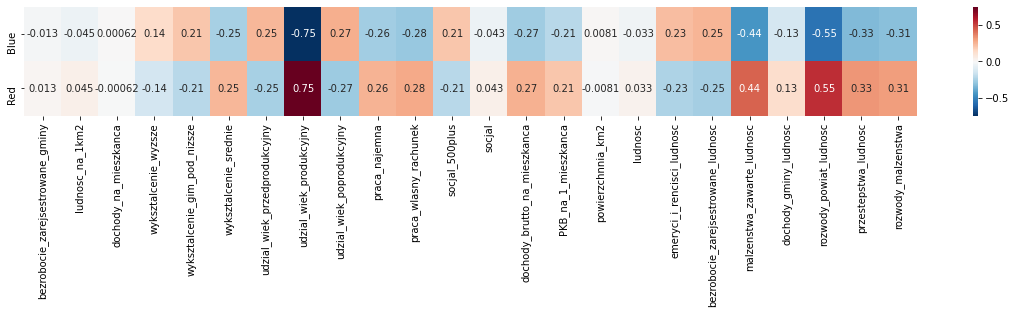

In [193]:
fig, ax = plt.subplots(figsize=(20,2))
sn.heatmap(pool_stat_df_org.corr().iloc[-2:,:-3], annot=True, cmap='RdBu_r', ax=ax)

plt.savefig('dane_pdf/dane_stat/all_correlations.pdf',  bbox_inches='tight')

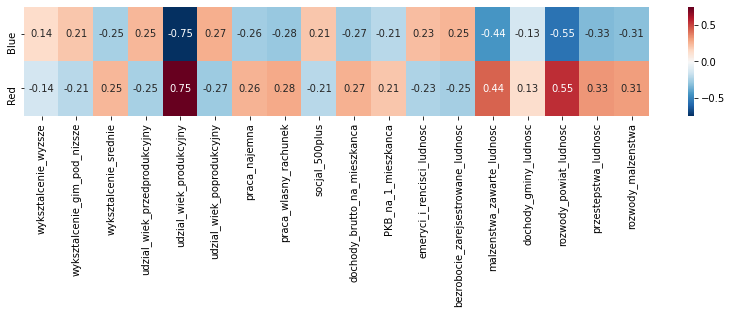

In [194]:
fig, ax = plt.subplots(figsize=(14,2))
pool_names_highcorr = (pool_stat_df_org
                       .corr()
                       .iloc[-2:,:-2][pool_stat_df_org
                                      .corr()
                                      .iloc[-2:,:-2]
                                      .abs() > 0.1]
                       .dropna(1))
sn.heatmap(pool_names_highcorr.dropna(1), annot=True, cmap='RdBu_r', ax=ax)
plt.savefig('dane_pdf/dane_stat/all_correlations_choosed.pdf',  bbox_inches='tight')

In [195]:
pool_names_highcorr

,wyksztalcenie_wyzsze,wyksztalcenie_gim_pod_nizsze,wyksztalcenie_srednie,udzial_wiek_przedprodukcyjny,udzial_wiek_produkcyjny,udzial_wiek_poprodukcyjny,praca_najemna,praca_wlasny_rachunek,socjal_500plus,dochody_brutto_na_mieszkanca,PKB_na_1_mieszkanca,emeryci_i_rencisci_ludnosc,bezrobocie_zarejsestrowane_ludnosc,malzenstwa_zawarte_ludnosc,dochody_gminy_ludnosc,rozwody_powiat_ludnosc,przestepstwa_ludnosc,rozwody_malzenstwa
Blue,0.13546,0.205325,-0.247968,0.24773,-0.747516,0.270503,-0.261207,-0.280812,0.20763,-0.26749,-0.210211,0.228949,0.25258,-0.438434,-0.12987,-0.550899,-0.328121,-0.313341
Red,-0.13546,-0.205325,0.247968,-0.24773,0.747516,-0.270503,0.261207,0.280812,-0.20763,0.26749,0.210211,-0.228949,-0.25258,0.438434,0.12987,0.550899,0.328121,0.313341


In [196]:
col_highcorr = pool_names_highcorr.columns.values.tolist()

In [197]:
for ch in col_highcorr:
    print('\item',ch )

\item wyksztalcenie_wyzsze
\item wyksztalcenie_gim_pod_nizsze
\item wyksztalcenie_srednie
\item udzial_wiek_przedprodukcyjny
\item udzial_wiek_produkcyjny
\item udzial_wiek_poprodukcyjny
\item praca_najemna
\item praca_wlasny_rachunek
\item socjal_500plus
\item dochody_brutto_na_mieszkanca
\item PKB_na_1_mieszkanca
\item emeryci_i_rencisci_ludnosc
\item bezrobocie_zarejsestrowane_ludnosc
\item malzenstwa_zawarte_ludnosc
\item dochody_gminy_ludnosc
\item rozwody_powiat_ludnosc
\item przestepstwa_ludnosc
\item rozwody_malzenstwa


In [198]:
col_not_na0 = stat_list_org[0].columns[stat_list_org[0].isna().sum(0) == 0]
col_not_na17 = stat_list_org[0].columns[stat_list_org[17].isna().sum(0) == 0]

In [199]:
df1_null = stat_list_org[0].count()
col_df1_null = df1_null[df1_null==0].index.values.tolist()

In [200]:
col_df1_null

['bezrobocie_zarejsestrowane_gminy',
 'dochody_na_mieszkanca',
 'udzial_wiek_przedprodukcyjny',
 'udzial_wiek_produkcyjny',
 'udzial_wiek_poprodukcyjny',
 'socjal_500plus',
 'przestepstwa_ogolem',
 'przestepstwa_ludnosc']

In [201]:
cols_to_fill = list(set(col_df1_null).intersection(col_highcorr))
cols_to_fill = cols_to_fill
cols_to_fill

['udzial_wiek_przedprodukcyjny',
 'przestepstwa_ludnosc',
 'socjal_500plus',
 'udzial_wiek_poprodukcyjny',
 'udzial_wiek_produkcyjny']

In [202]:
dflast_null = stat_list_org[-1].count()
col_dflast_null = dflast_null[dflast_null==0].index.values.tolist()
cols_to_fill_last = list(set(col_dflast_null).intersection(col_highcorr))
cols_to_fill_last

['dochody_brutto_na_mieszkanca']

Selecting columns:
- udzial_wiek_produkcyjny 
- udzial_wiek_przedprodukcyjny
- udzial_wiek_poprodukcyjny
- przestepstwa_ogolem
- dochody_brutto_na_mieszkanca (for last)

In [203]:
df_sel_null_col = pd.DataFrame(columns=cols_to_fill+cols_to_fill_last+['ludnosc_na_1km2'])
for s in stat_list_org:
    cols_list = df_sel_null_col.columns.values.tolist()
    df_sel_null_col = df_sel_null_col.append(s[cols_list])

### udzial_wiek_produkcyjny

In [204]:
def lq(x, a, b, c):
    return x*x*a + x*b + c

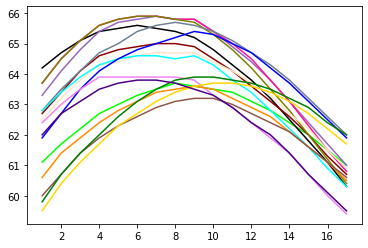

In [205]:
data_reshaped = df_sel_null_col['udzial_wiek_produkcyjny'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/udzial_wiek_produkcyjny_all.pdf',  bbox_inches='tight')

In [206]:
data_reshaped.shape

(18, 16)

MAŁOPOLSKIE           RMSE 0.0038150306562253766
ŚLĄSKIE               RMSE 0.010225520548776748
LUBUSKIE              RMSE 0.032914769623019605
WIELKOPOLSKIE         RMSE 0.029697383597401848
ZACHODNIOPOMORSKIE    RMSE 0.017715959448794717
DOLNOŚLĄSKIE          RMSE 0.022857706550112062
OPOLSKIE              RMSE 0.012787895343895975
KUJAWSKO-POMORSKIE    RMSE 0.011256905238875656
POMORSKIE             RMSE 0.01374127359922268
WARMIŃSKO-MAZURSKIE   RMSE 0.00923298731257192
ŁÓDZKIE               RMSE 0.01986037758756752
ŚWIĘTOKRZYSKIE        RMSE 0.0059309172585441305
LUBELSKIE             RMSE 0.004243003703029074
PODKARPACKIE          RMSE 0.005847447338068247
PODLASKIE             RMSE 0.0008501790809202414
MAZOWIECKIE           RMSE 0.014280033995022024


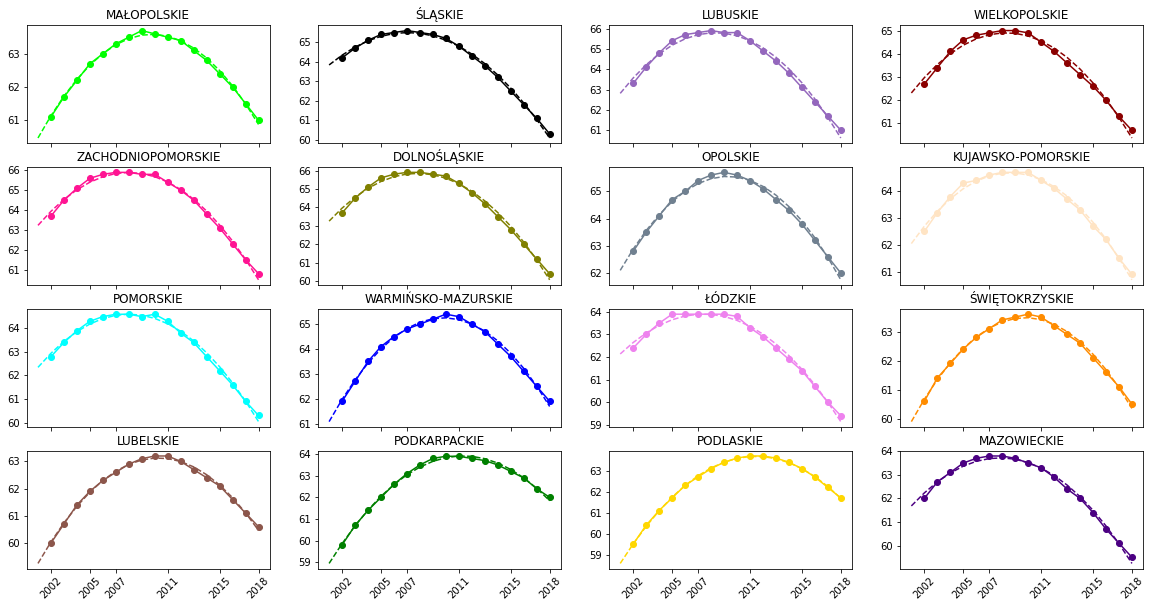

In [207]:
fig = plt.figure(1, figsize=(20,10)) 
x = np.arange(17)
for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    perr = np.sqrt(np.diag(pcov))

    print(df_sel_null_col.index[w].ljust(20)," RMSE",np.sum((data_reshaped[1:,w]-ymodel[1:])**2)/ymodel[1:].shape[0])
    stat_list_org[0]['udzial_wiek_produkcyjny'][w] = ymodel[0]
    ax1 = fig.add_subplot(4,4,w+1)
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[1:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
        
    stat_list_org[0]['udzial_wiek_produkcyjny'][w] = ymodel[0]
plt.savefig('dane_pdf/dane_stat/udzial_wiek_produkcyjny.pdf',  bbox_inches='tight')

### udzial_wiek_przedprodukcyjny

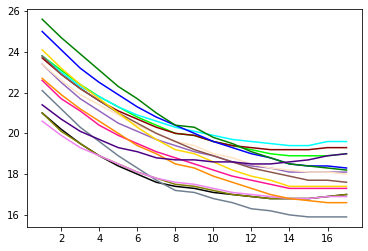

In [208]:
data_reshaped = df_sel_null_col['udzial_wiek_przedprodukcyjny'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/udzial_wiek_przedprodukcyjny_all.pdf',  bbox_inches='tight')

MAŁOPOLSKIE           RMSE 0.004825775511442974
ŚLĄSKIE               RMSE 0.01353487525040982
LUBUSKIE              RMSE 0.011480301098767532
WIELKOPOLSKIE         RMSE 0.0073535482304376365
ZACHODNIOPOMORSKIE    RMSE 0.007275238268682167
DOLNOŚLĄSKIE          RMSE 0.010096825107752026
OPOLSKIE              RMSE 0.015084987555393876
KUJAWSKO-POMORSKIE    RMSE 0.0037977296181630417
POMORSKIE             RMSE 0.00702998846597465
WARMIŃSKO-MAZURSKIE   RMSE 0.0055484732592727785
ŁÓDZKIE               RMSE 0.007325016693984078
ŚWIĘTOKRZYSKIE        RMSE 0.003784070903903387
LUBELSKIE             RMSE 0.0030070418260183503
PODKARPACKIE          RMSE 0.009793298124203317
PODLASKIE             RMSE 0.00494111576519157
MAZOWIECKIE           RMSE 0.013645359072421447


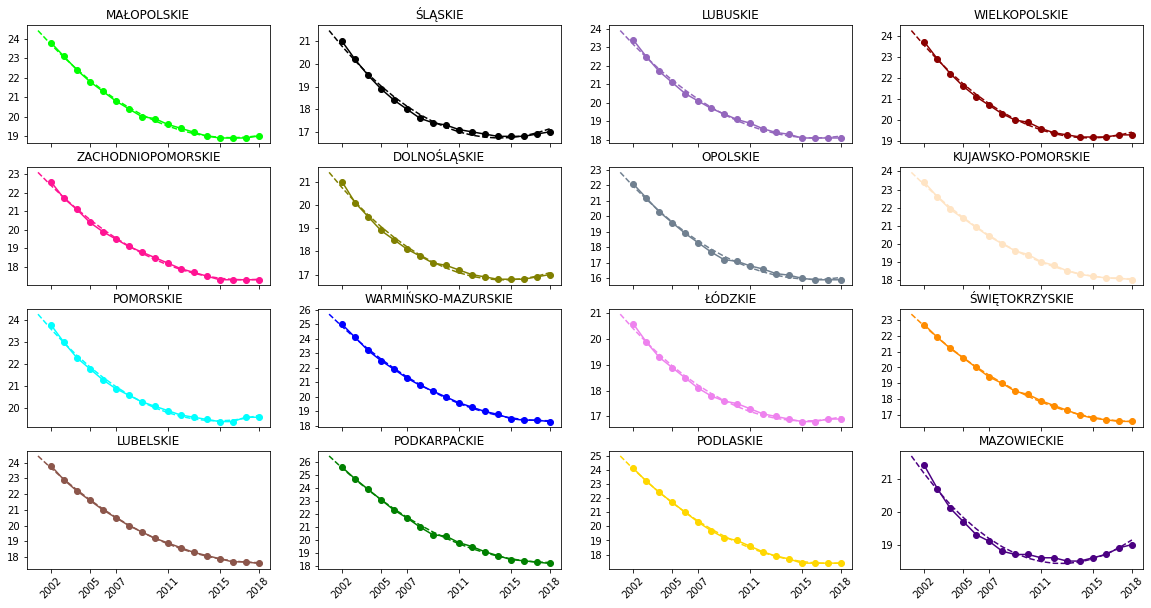

In [209]:
fig = plt.figure(1, figsize=(20,10)) 
x = np.arange(17)
for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    perr = np.sqrt(np.diag(pcov))

    print(df_sel_null_col.index[w].ljust(20)," RMSE",np.sum((data_reshaped[1:,w]-ymodel[1:])**2)/ymodel[1:].shape[0])
    stat_list_org[0]['udzial_wiek_przedprodukcyjny'][w] = ymodel[0]
    ax1 = fig.add_subplot(4,4,w+1)
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[1:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
        
    stat_list_org[0]['udzial_wiek_przedprodukcyjny'][w] = ymodel[0]
plt.savefig('dane_pdf/dane_stat/udzial_wiek_przedprodukcyjny.pdf',  bbox_inches='tight')

### udzial_wiek_poprodukcyjny

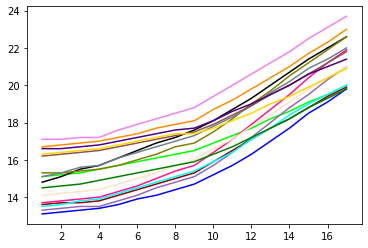

In [210]:
data_reshaped = df_sel_null_col['udzial_wiek_poprodukcyjny'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/udzial_wiek_poprodukcyjny_all.pdf',  bbox_inches='tight')

MAŁOPOLSKIE           RMSE 0.00316396527651308
ŚLĄSKIE               RMSE 0.007505311722211999
LUBUSKIE              RMSE 0.016178898804403423
WIELKOPOLSKIE         RMSE 0.015075881745887513
ZACHODNIOPOMORSKIE    RMSE 0.0130458932799202
DOLNOŚLĄSKIE          RMSE 0.016595641352516143
OPOLSKIE              RMSE 0.00845231591088442
KUJAWSKO-POMORSKIE    RMSE 0.008168518181266456
POMORSKIE             RMSE 0.01249559885873848
WARMIŃSKO-MAZURSKIE   RMSE 0.006106962909082264
ŁÓDZKIE               RMSE 0.010684453347902865
ŚWIĘTOKRZYSKIE        RMSE 0.006365264372081888
LUBELSKIE             RMSE 0.005254659139197894
PODKARPACKIE          RMSE 0.004853092939962439
PODLASKIE             RMSE 0.007789716505800923
MAZOWIECKIE           RMSE 0.007950889334073284


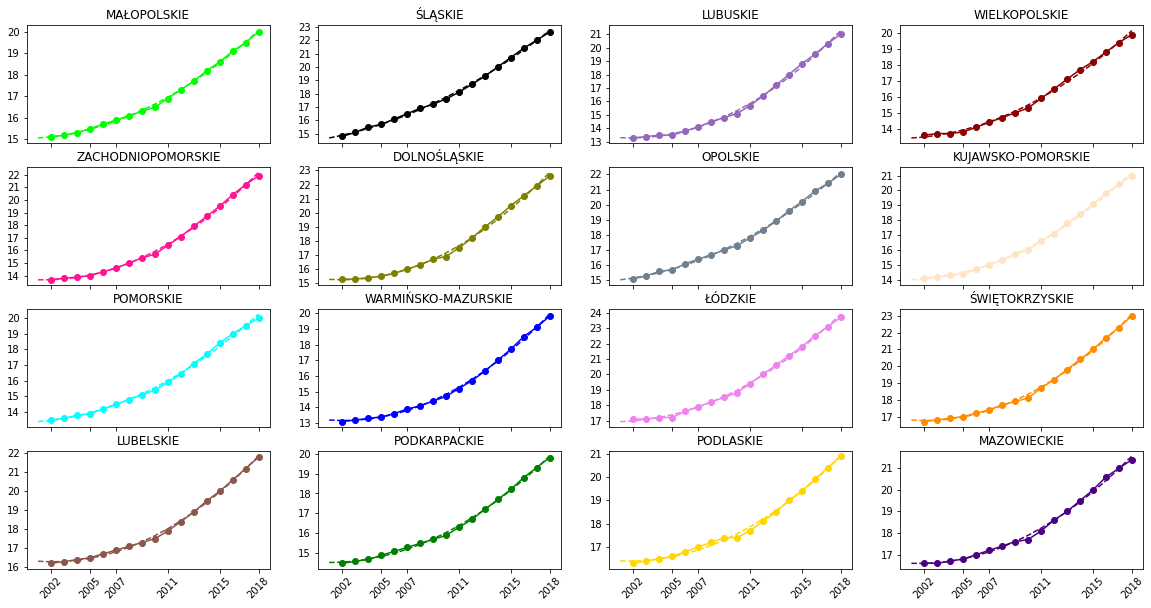

In [211]:
fig = plt.figure(1, figsize=(20,10))

x = np.arange(17)
for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    perr = np.sqrt(np.diag(pcov))

    print(df_sel_null_col.index[w].ljust(20)," RMSE",np.sum((data_reshaped[1:,w]-ymodel[1:])**2)/ymodel[1:].shape[0])
    stat_list_org[0]['udzial_wiek_poprodukcyjny'][w] = ymodel[0]
    ax1 = fig.add_subplot(4,4,w+1)
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[1:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
        
    stat_list_org[0]['udzial_wiek_poprodukcyjny'][w] = ymodel[0]
plt.savefig('dane_pdf/dane_stat/udzial_wiek_poprodukcyjny.pdf',  bbox_inches='tight')

### przestepstwa_ogolem

In [212]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing

In [213]:
def lq_sin(x, a, b, c, d):
    return np.sin(x/a*np.pi)*b + x*c + d

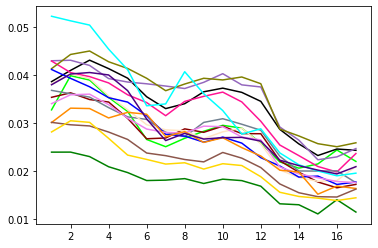

In [214]:
data_reshaped = df_sel_null_col['przestepstwa_ludnosc'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/przestepstwa_ludnosc_all.pdf',  bbox_inches='tight')

#### MINMAX rescaling

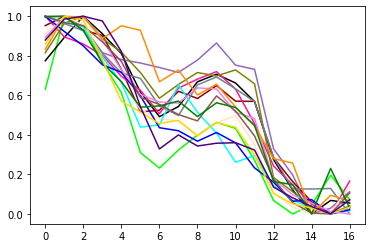

In [215]:
minmax_data_reshaped = preprocessing.minmax_scale(data_reshaped[~np.isnan(data_reshaped)].reshape(17,-1))
for x in range(minmax_data_reshaped.shape[1]):
    plt.plot(minmax_data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1] )
plt.savefig('dane_pdf/dane_stat/przestepstwa_ludnosc_all.pdf',  bbox_inches='tight')

#### Comparing each year with best line

In [216]:
notnull_data_reshaped = data_reshaped[~np.isnan(data_reshaped)].reshape(17,-1)

In [217]:
mx = notnull_data_reshaped.max(0)
mn = notnull_data_reshaped.min(0)

MAŁOPOLSKIE           RMSE minmax 0.10159950018252682  RMSE 3.760434896534175e-05
ŚLĄSKIE               RMSE minmax 0.10284964205116577  RMSE 4.0500741763200743e-05
LUBUSKIE              RMSE minmax 0.26965514620904707  RMSE 0.0001156695032832995
WIELKOPOLSKIE         RMSE minmax 0.05532254975537902  RMSE 2.160596817793382e-05
ZACHODNIOPOMORSKIE    RMSE minmax 0.10444152567119525  RMSE 5.567933303552253e-05
DOLNOŚLĄSKIE          RMSE minmax 0.19400485932482214  RMSE 7.69586217744842e-05
OPOLSKIE              RMSE minmax 0.08140556446554996  RMSE 3.005830035374502e-05
KUJAWSKO-POMORSKIE    RMSE minmax 0.028122580548659022  RMSE 1.4025168027181782e-05
POMORSKIE             RMSE minmax 0.06255714701293735  RMSE 6.89557247919933e-05
WARMIŃSKO-MAZURSKIE   RMSE minmax 0.02916912460607001  RMSE 1.6688740380454326e-05
ŁÓDZKIE               RMSE minmax 0.052388322760763835  RMSE 1.7714073897048288e-05
ŚWIĘTOKRZYSKIE        RMSE minmax 0.17343759930856817  RMSE 5.559125094388598e-05
LUBELSKIE   

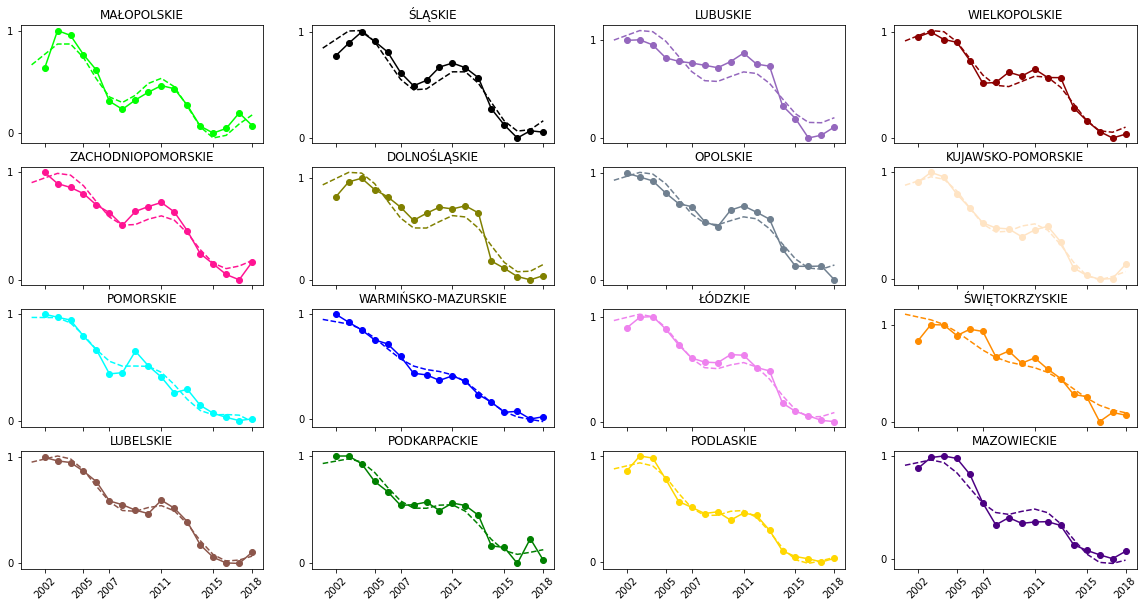

In [218]:
x = np.arange(17)

fig = plt.figure(1, figsize=(20,10))
 
for w in range(data_reshaped.shape[1]):
    (a,b,c,d), pcov = curve_fit(lq_sin, 
                                x, 
                                minmax_data_reshaped[:,w], # data_reshaped[1:,w], 
                                p0=[4,6,-1,1], maxfev = 100000)
    xmodel = np.arange(-1,17)
    ymodel = lq_sin(xmodel, a,b,c,d)
    perr = np.sqrt(np.diag(pcov))
    ax1 = fig.add_subplot(4,4,w+1)
    
    plt.xticks(range(-1,17), rotation=45)
    print(df_sel_null_col.index[w].ljust(20),
          " RMSE minmax",
          np.sum((minmax_data_reshaped[:,w]-ymodel[1:])**2),
          " RMSE",
          np.sum((data_reshaped[1:,w]-(ymodel[1:]*(mx[w]-mn[w])+mn[w]))**2),
         )
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, minmax_data_reshaped[:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
    
    #stat_list_org[0]['przestepstwa_ludnosc'][w] = stat_list_org[-1]['przestepstwa_ludnosc'][w] 
    stat_list_org[0]['przestepstwa_ludnosc'][w] = stat_list_org[1]['przestepstwa_ludnosc'][w]
    stat_list_org[0]['przestepstwa_ludnosc'][w] = ymodel[0]
    
plt.savefig('dane_pdf/dane_stat/przestepstwa_ogolem.pdf',  bbox_inches='tight')

### dochody_brutto_na_mieszkanca

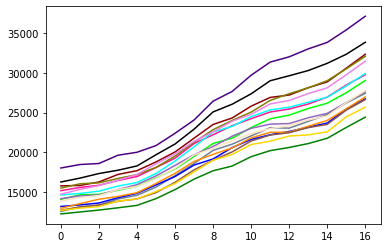

In [219]:
data_reshaped = df_sel_null_col['dochody_brutto_na_mieszkanca'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/dochody_brutto_na_mieszkanca_all.pdf',  bbox_inches='tight')

In [220]:
def lq3(x, a, b, c, d):
    return x*x*x*a + x*x*b + x*c + d

def lq1(x, a, b):
    return x*a + b 

x = np.arange(17)

MAŁOPOLSKIE           RMSE 169448.68592545387
ŚLĄSKIE               RMSE 203500.1347356281
LUBUSKIE              RMSE 243984.4849754144
WIELKOPOLSKIE         RMSE 245250.37332301334
ZACHODNIOPOMORSKIE    RMSE 224842.738890912
DOLNOŚLĄSKIE          RMSE 156643.0795544224
OPOLSKIE              RMSE 246577.29240272002
KUJAWSKO-POMORSKIE    RMSE 238045.01364353797
POMORSKIE             RMSE 344296.1609603593
WARMIŃSKO-MAZURSKIE   RMSE 201676.98450494738
ŁÓDZKIE               RMSE 173722.11468767028
ŚWIĘTOKRZYSKIE        RMSE 222381.79968736775
LUBELSKIE             RMSE 239741.42041522445
PODKARPACKIE          RMSE 152630.55433133026
PODLASKIE             RMSE 263450.5313088086
MAZOWIECKIE           RMSE 217268.27082195086


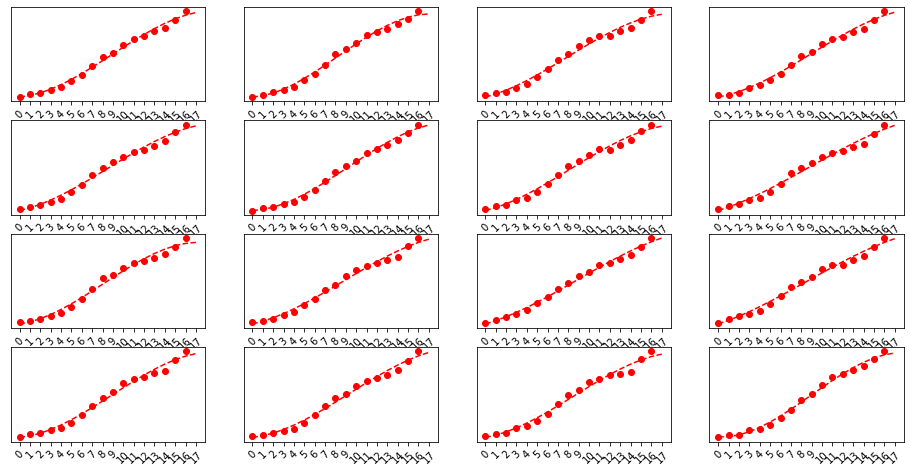

In [221]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))
 
for w in range(data_reshaped.shape[1]):
    (a,b,c,d), pcov = curve_fit(lq3, x, data_reshaped[:-1,w], p0=[1,1,1,1])
    xmodel = np.arange(18)
    ymodel = lq3(xmodel, a, b, c,d)
    perr = np.sqrt(np.diag(pcov))
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[:-1,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    ax1.set_yticks([]) 
    plt.xticks(range(18), rotation=45)
    #print("%s" % " ".join(starmap("{}={}+-{} ".format,
    #        zip(['a','b','c','d'],
    #            np.round([a,b,c,d],4), 
    #            np.round(perr,4)))) + ' r2={r}'.format(r=np.round(r2_score(data_reshaped[:-1,w], ymodel[:-1]),2)))
    print(df_sel_null_col.index[w].ljust(20)," RMSE",np.sum((data_reshaped[:-1,w]-ymodel[:-1])**2)/ymodel[1:].shape[0])

    stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.savefig('dane_pdf/dane_stat/dochody_brutto_na_mieszkanca.pdf',  bbox_inches='tight')

MAŁOPOLSKIE           RMSE 386181.6192329873
ŚLĄSKIE               RMSE 568363.9256055367
LUBUSKIE              RMSE 329078.50461360975
WIELKOPOLSKIE         RMSE 415894.5668973471
ZACHODNIOPOMORSKIE    RMSE 325802.22087658563
DOLNOŚLĄSKIE          RMSE 514258.38739907695
OPOLSKIE              RMSE 345308.57208765874
KUJAWSKO-POMORSKIE    RMSE 276965.28892733576
POMORSKIE             RMSE 548342.3108419839
WARMIŃSKO-MAZURSKIE   RMSE 284298.8350634374
ŁÓDZKIE               RMSE 246167.72880622803
ŚWIĘTOKRZYSKIE        RMSE 254498.7091983851
LUBELSKIE             RMSE 422668.19939446385
PODKARPACKIE          RMSE 293499.97866205295
PODLASKIE             RMSE 366730.03099769336
MAZOWIECKIE           RMSE 868603.145184544


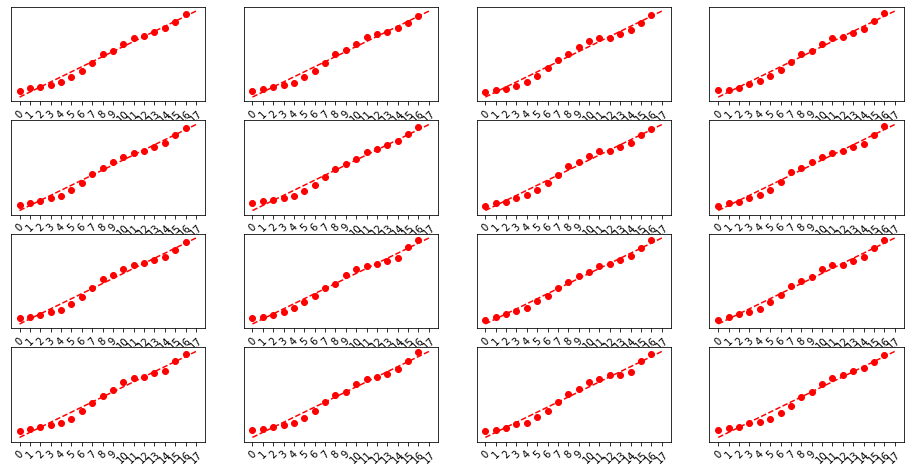

In [222]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))
 
for w in range(data_reshaped.shape[1]):
    (a,b), pcov = curve_fit(lq1, x, data_reshaped[:-1,w], p0=[1,1])
    xmodel = np.arange(18)
    ymodel = lq1(xmodel, a, b)
    perr = np.sqrt(np.diag(pcov))
    ax1 = fig.add_subplot(4,4,w+1)
    ax1.plot(x, data_reshaped[:-1,w], "ro", label="Experiment")
    ax1.plot(xmodel,ymodel, "r--", label="Model")
    plt.xticks(range(18), rotation=45)
    ax1.set_yticks([]) 
    #print("%s" % " ".join(starmap("{}={}+-{} ".format,
    #        zip(['a','b'],
    #            np.round([a,b],4), 
    #            np.round(perr,4)))) + ' r2={r}'.format(r=np.round(r2_score(data_reshaped[:-1,w], ymodel[:-1]),2)))
    print(df_sel_null_col.index[w].ljust(20)," RMSE",np.sum((data_reshaped[:-1,w]-ymodel[:-1])**2)/ymodel[1:].shape[0])

    stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = stat_list_org[-2]['dochody_brutto_na_mieszkanca'][w]
plt.savefig('dane_pdf/dane_stat/dochody_brutto_na_mieszkanca_simplermodel.pdf',  bbox_inches='tight')

## Compare correlations after rescaling

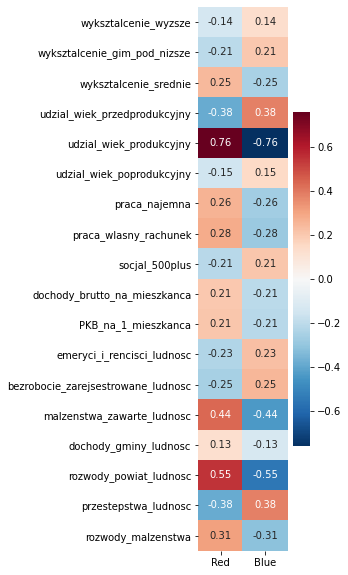

In [223]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)

for w, c in enumerate([
    'emeryci_i_rencisci',
    'bezrobocie_zarejsestrowane',
    'malzenstwa_zawarte',
    'dochody_gminy',
    'rozwody_powiat',
    'przestepstwa_ogolem']):
    pool_stat_df_org = pool_stat_df_org.drop(c, axis=1)

fig, ax = plt.subplots(figsize=(2,10))
sn.heatmap(pool_stat_df_org[pool_names_highcorr.columns.values.tolist()+['Red','Blue']].corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

## Rescale the data

In [224]:
col_not_na0 = stat_list_org[0].columns[stat_list_org[0].isna().sum(0) == 0]
col_not_na17 = stat_list_org[0].columns[stat_list_org[17].isna().sum(0) == 0]

In [225]:
stat_list_minmax = stat_list_org.copy()
stat_list_mean = stat_list_org.copy()

In [226]:
#MINMAX scaling
for st in range(len(stat_list_org)):
    stat_list_minmax[st] = stat_list_org[st][col_not_na0 & col_not_na17].copy()
    # min max normalization
    stat_list_minmax[st] = (stat_list_minmax[st]-stat_list_minmax[st].min(0)) / (stat_list_minmax[st].max(0)-stat_list_minmax[st].min(0))

In [227]:
#NORLAMISATION
for st in range(len(stat_list_org)):
    stat_list_mean[st] = stat_list_org[st][col_not_na0 & col_not_na17].copy()
    # nrmalization mean (around 0)
    stat_list_mean[st] = (stat_list_mean[st]-stat_list_mean[st].mean(0)) / (stat_list_mean[st].std(0))

In [228]:
stat_list = stat_list_mean if (True) else stat_list_minmax

## Examining stat data

In [229]:
len(stat_list)

18

In [230]:
len(stat_list_org)

18

In [231]:
len(pool_d[:-1])

18

In [232]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list, pool_d[1:])]
pool_stat_m = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_mean, pool_d[1:])]
pool_stat_mm = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_minmax, pool_d[1:])]

In [233]:
pool_stat_df_org =  pd.concat(pool_stat_org).reset_index(drop=True)
pool_stat_df_m = pd.concat(pool_stat_m).reset_index(drop=True)
pool_stat_df_mm = pd.concat(pool_stat_mm).reset_index(drop=True)

In [234]:
for w, c in enumerate([
    'emeryci_i_rencisci',
    'bezrobocie_zarejsestrowane',
    'malzenstwa_zawarte',
    'dochody_gminy',
    'rozwody_powiat']):
    pool_stat_df_org = pool_stat_df_org.drop(c, axis=1)
    pool_stat_df_m = pool_stat_df_m.drop(c, axis=1)
    pool_stat_df_mm = pool_stat_df_mm.drop(c, axis=1)

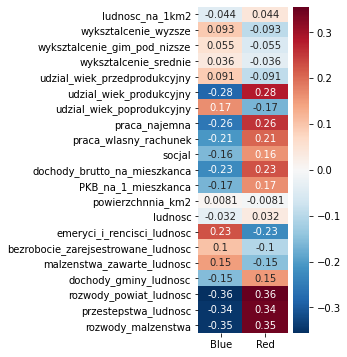

In [235]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_m.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

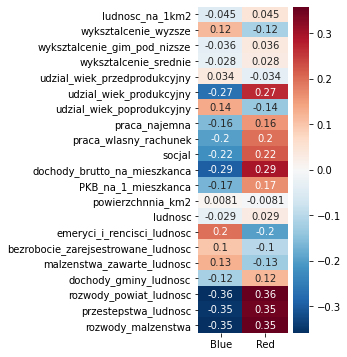

In [236]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_mm.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

In [239]:
potential_cols = pool_stat_df_mm.corr().iloc[:-2,-1].abs()
potential_cols = potential_cols[potential_cols>0.1]
high_cols = potential_cols.index.values.tolist()

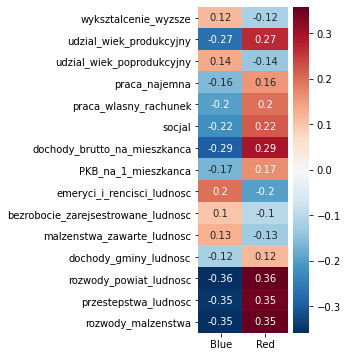

In [241]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_mm.corr().loc[high_cols,['Blue','Red']], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

In [246]:
high_cols = [#'rozwody_powiat',
 'udzial_wiek_produkcyjny',
 'udzial_wiek_poprodukcyjny',
 'praca_najemna',
 'praca_wlasny_rachunek',
 'socjal',
 'dochody_brutto_na_mieszkanca',
 'PKB_na_1_mieszkanca',
 #'przestepstwa_ogolem',
 'przestepstwa_ludnosc',
 'emeryci_i_rencisci_ludnosc',
 'bezrobocie_zarejsestrowane_ludnosc',
 'malzenstwa_zawarte_ludnosc',
 'dochody_gminy_ludnosc',
 'rozwody_powiat_ludnosc',
 'rozwody_malzenstwa'
]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['udzial_wiek_poprodukcyjny', 'dochody_brutto_na_mieszkanca',\n       'przestepstwa_ludnosc'],\n      dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

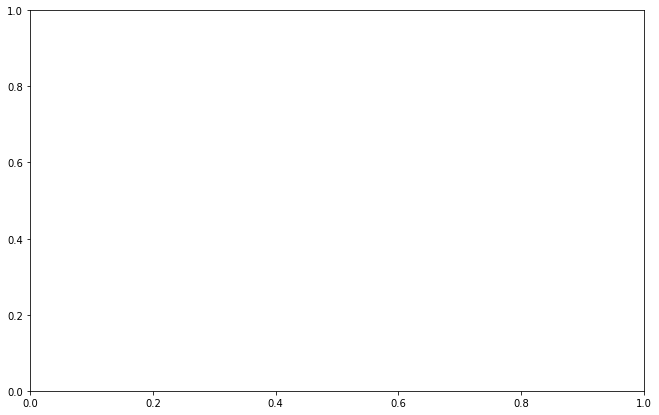

In [247]:
fig, ax = plt.subplots(figsize=(11,7))
sn.heatmap(pool_stat_df_mm.corr().loc[high_cols,high_cols], annot=True, cmap='RdBu_r')
plt.savefig('dane_pdf/dane_stat/corr_between.pdf',  bbox_inches='tight')

### Lasso

In [248]:
X = pool_stat_df_m.iloc[:,1:-2].values
Y = pool_stat_df_m.iloc[:,-1].values

In [249]:
clf = Lasso(alpha=0.001)
clf.fit(X, Y)

Lasso(alpha=0.001)

In [253]:
df_lasso = pd.DataFrame({"weights":np.abs(clf.coef_), "names":pool_stat_df_m.columns[1:-2]})

In [254]:
df_lasso.sort_values("weights", ascending = False)[:10]

,weights,names
19,0.041399,rozwody_powiat_ludnosc
9,0.025656,praca_najemna
1,0.019854,bezrobocie_zarejsestrowane
8,0.018247,udzial_wiek_produkcyjny
6,0.013407,wyksztalcenie_srednie
3,0.011672,ludnosc_na_1km2
12,0.010966,PKB_na_1_mieszkanca
4,0.009750,dochody_gminy
15,0.009587,emeryci_i_rencisci_ludnosc
16,0.009475,bezrobocie_zarejsestrowane_ludnosc


### Random Forest

In [255]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, Y)

RandomForestRegressor(max_depth=2, random_state=0)

In [256]:
df_rand = pd.DataFrame({"importance":regr.feature_importances_, "names":pool_stat_df_m.columns[1:-2]})

In [257]:
df_rand.sort_values("importance", ascending = False)[:10]

,importance,names
9,0.372120,praca_najemna
20,0.124882,rozwody_malzenstwa
8,0.117307,udzial_wiek_produkcyjny
12,0.069497,PKB_na_1_mieszkanca
18,0.061198,dochody_gminy_ludnosc
19,0.056542,rozwody_powiat_ludnosc
10,0.047829,praca_wlasny_rachunek
14,0.023922,ludnosc
5,0.021137,wyksztalcenie_gim_pod_nizsze
2,0.019797,malzenstwa_zawarte


### PCA

In [258]:
pca = PCA(n_components=10)
x_new = pca.fit_transform(X)

In [259]:
pca.explained_variance_ratio_

array([0.46172808, 0.16972808, 0.12991465, 0.06360818, 0.04698783,
       0.03097145, 0.02894797, 0.02009746, 0.01402245, 0.01234339])

In [260]:
color_list = []
for w in pool_stat_df_m['index']:
    if w == 'MAŁOPOLSKIE': color_list.append('C0')
    elif w == 'ŚLĄSKIE': color_list.append('C1')
    elif w == 'LUBUSKIE': color_list.append('C2')
    elif w == 'WIELKOPOLSKIE': color_list.append('C3')
    elif w == 'ZACHODNIOPOMORSKIE': color_list.append('C4')
    elif w == 'DOLNOŚLĄSKIE': color_list.append('C5')
    elif w == 'OPOLSKIE': color_list.append('C6')
    elif w == 'KUJAWSKO-POMORSKIE': color_list.append('C7')
    elif w == 'POMORSKIE': color_list.append('C8')
    elif w == 'WARMIŃSKO-MAZURSKIE': color_list.append('C9')
    elif w == 'ŁÓDZKIE': color_list.append('C10')
    elif w == 'ŚWIĘTOKRZYSKIE': color_list.append('C11')
    elif w == 'LUBELSKIE': color_list.append('C12')
    elif w == 'PODKARPACKIE': color_list.append('C13')
    elif w == 'PODLASKIE': color_list.append('C14')
    elif w == 'MAZOWIECKIE': color_list.append('C15')

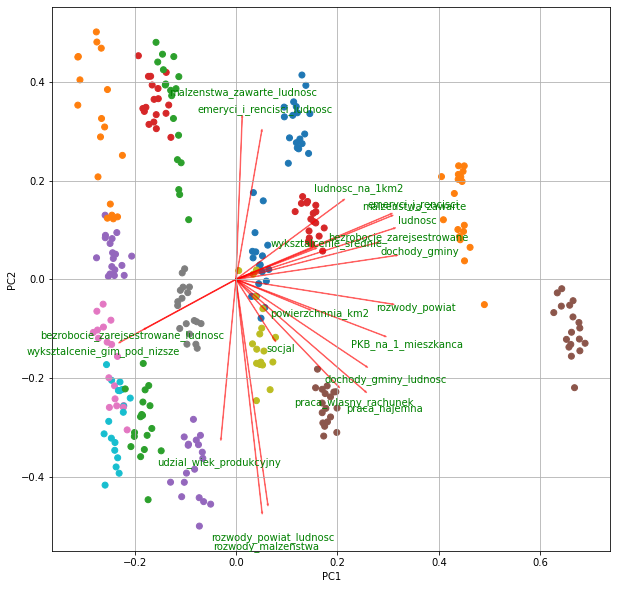

In [262]:
cols_plotting = pool_stat_df_m.columns[1:-2] 
plt.figure(figsize=(10,10))

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = color_list)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, cols_plotting[i], color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [145]:
high_cols = [
 'udzial_wiek_produkcyjny',
 #'udzial_wiek_poprodukcyjny',
 'praca_najemna',
 #'praca_wlasny_rachunek',
 'socjal',
 #'dochody_brutto_na_mieszkanca',
 #'PKB_na_1_mieszkanca',
 'przestepstwa_ludnosc',
 'emeryci_i_rencisci_ludnosc',
 'bezrobocie_zarejsestrowane_ludnosc',
 'malzenstwa_zawarte_ludnosc'
 #'dochody_gminy_ludnosc',
 #'rozwody_powiat_ludnosc'
 #'rozwody_malzenstwa'
]

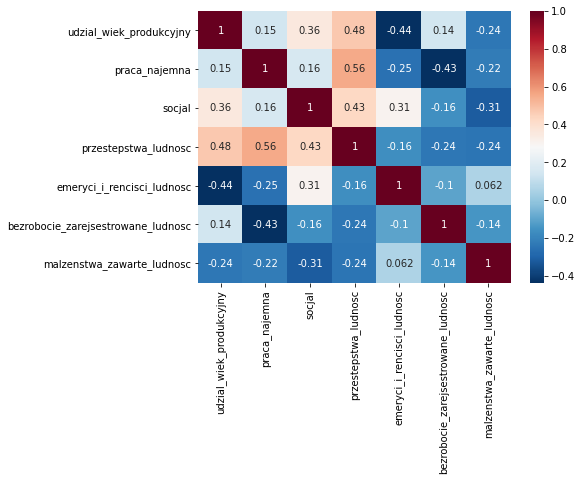

In [146]:
fig, ax = plt.subplots(figsize=(7,5))
sn.heatmap(pool_stat_df_mm.corr().loc[high_cols,high_cols], annot=True, cmap='RdBu_r')
plt.savefig('dane_pdf/dane_stat/corr_between_choosen.pdf',  bbox_inches='tight')

In [147]:
stat_list = [st.loc[:,high_cols] for st in stat_list]

# Model

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [148]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(len(stat_list)):
    # iterate over districts
    tmp_x = []
    st_data = stat_list[y]
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [pool_d[y].loc[n.upper()][0]/pool_d[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(lo[0]/lo.sum())
        tmp_y.append(avg_n)
                
        tmp_x.append(tmp_y)
    X.append(tmp_x)

In [149]:
X = np.array(X)
X.shape

(18, 16, 9)

## Prepare Y

In [150]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [151]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [152]:
X.shape

(18, 16, 9)

### Models with percentage of Blue support per district

In [153]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    OUTPUT:
    y - predicted value in (0,1)
    '''
    #d0 = x.shape[0] if (len(x.shape) == 3) else 1
    #d1 = x.shape[-1] 
    
    #a = np.repeat(a, d0, 0)
    #x = x.reshape(-1, d1) 
    
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))
    return y

def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    y = y.reshape(-1, 1)
    y1 = -(2 * 
          ( y - 1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2 *
          np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) *
          x) 
    return y1

In [154]:
"""
def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    y = y.reshape(-1, 1)
    m = np.sign(y - model_percent(a,x))
    y1 =m*(2 * 
          ( y - 1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2 *
          np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) *
          x) 
    return y1
"""

"\ndef grad_percent(a,x,y):\n    '''\n    INPUT:\n    a - vector of weights 16x14\n    x - vector of input data 18x16x14\n    '''\n    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2\n    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2\n    d0 = x.shape[0] if (len(x.shape) == 3) else 1\n    d1 = x.shape[-1] \n    \n    a = np.repeat(a, d0, 0)\n    x = x.reshape(-1, d1)\n    y = y.reshape(-1, 1)\n    m = np.sign(y - model_percent(a,x))\n    y1 =m*(2 * \n          ( y - 1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True))) ) * \n          1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2 *\n          np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) *\n          x) \n    return y1\n"

### Setup for testing model

In [155]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = par_in_reg_list[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = par_in_reg_list[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

In [156]:
st_data.shape

(16, 7)

In [157]:
def prepare_input(y, st_data):
    tmp_x = np.zeros((y.shape[0],st_data.shape[-1]+2))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(y[d,0])
        tmp_y.append(avg_n)
        
        tmp_x[d] = np.array(tmp_y)
    return(tmp_x)

In [158]:
def model(a,x,Y,st_list):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        st_data = stat_list[year-1]
        xi = prepare_input(y,st_list[year-1])
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

In [159]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
#av = np.random.rand(X.shape[1],X.shape[2])

step = 0.01
beta = 0.1
a_avg.shape

(16, 9)

## Use output -> next input (grad each step)

loss: 0.9345064735683869
loss: 2.039994279937874
loss: 2.2334322781063523
loss: 2.3894938394330025
loss: 2.4852253158119497
loss: 2.5425851524561094
loss: 2.5693668693215463
loss: 2.575346871653548
loss: 2.6101507614082515
loss: 2.6455970530484354


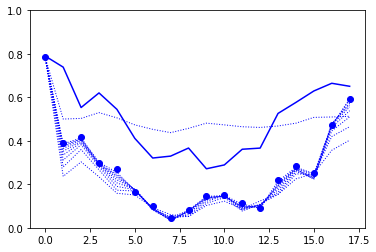

In [165]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 0.1 

loss_arr = np.zeros((10**3,))

loss_prev = np.inf

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)
    
    loss_arr[epoch] = loss_p
    #if loss_p < loss_prev:
    #    step = step*0.95
    #else:
    #    step = step*1.05
    
    #loss_prev = loss_p
            
    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        print('loss:', np.mean(l))
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

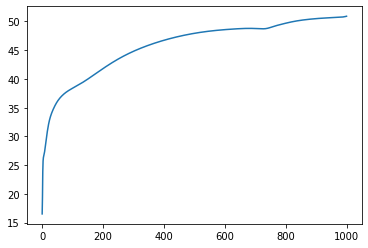

In [166]:
plt.plot(loss_arr)
plt.show()

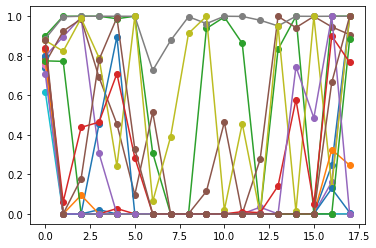

In [161]:
plt.plot(o.reshape(-1,16),'o-')
plt.show()

### Compare of parameters per each district

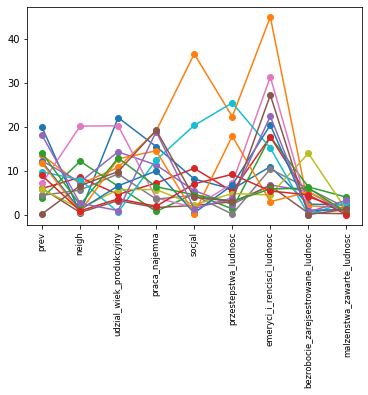

In [508]:
plt.plot(np.abs(a_step.T), 'o-')
plt.xticks(range(a_step.shape[1]), ['prev','neigh']+high_cols, size='small',rotation=90)
plt.show()

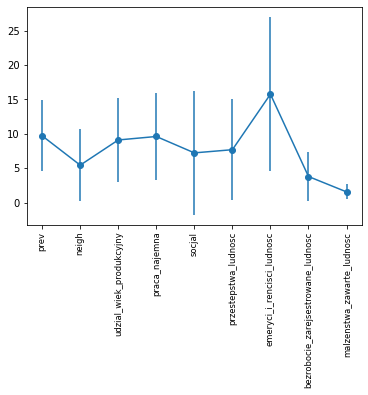

In [518]:
plt.plot(np.abs(a_step).mean(0), 'o-')
plt.errorbar(np.arange(9), np.abs(a_step).mean(0), e, linestyle='None', marker='', ecolor='tab:blue')
e = np.abs(a_step).std(0)
plt.xticks(range(a_step.shape[1]), ['prev','neigh']+high_cols, size='small',rotation=90)
plt.show()

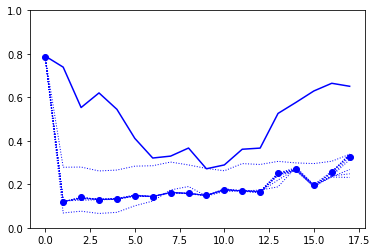

In [102]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 1

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-343-93f592a7281f>:15: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


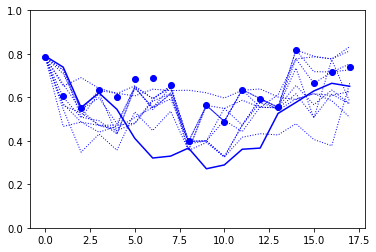

In [380]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 10

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

## All at once + evolution strategies (TO DO)

# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
for epoch in range(10**3):
    grad = grad_percent(a_avg,X).reshape(18,16,3)
    grad = np.sum(grad, axis=0)
    a_avg = a_avg - step*grad
    
    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)
a_avg.shape

[]

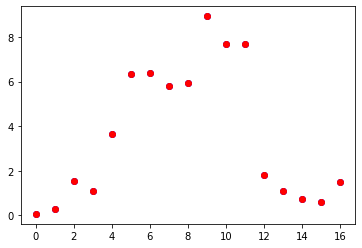

In [264]:
l_avg, o = model(a_avg,X,Y)
l_all, o = model(a_all,X,Y)
plt.plot(l_avg,'bo')
plt.plot(l_all,'ro')
plt.plot()

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
http://proceedings.mlr.press/v57/zhao16.pdf <br>
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816 <br>
https://developer.apple.com/documentation/coreml/core_ml_api/making_predictions_with_a_sequence_of_inputs <br>
https://www.youtube.com/watch?v=WCUNPb-5EYI

In [56]:
(a_avg-a_all).max()

0.004963590920596506